#Implementación de un modelo de Deep Learning

#Introducción

El presente trabajo aborda la clasificación automática de escenas naturales mediante técnicas de aprednizaje profundo (_deep learning_). El problema busca que el modelo identifique el entorno representado en una imagen—como un bosque o el mar— a partir de patrones visuales complejo. La clasificación de escenas es una tarea fundamental en áreas como análisis geográfico y gestión ambiental, así como la construcción de grandes bases de imágenes digitales. Correspondientemente, representa un desafío dado que el modelo debe reconocer estructuras, texturas y diferentes patrones en condiciones diversas.

Para el desarrollo se utilizó el dataset Intel Image Classification de Kaggle (Apéndice 1). Éste contiene seis categorías correspondientes a: _buildings_, _forest_, _glacier_, _mountain_, _sea_ y _street_. Las imágenes contienen una amplia variabilidad visual, incluyendo fondos, perspectivas y condiciones de iluminación. Por lo tanto, el datatset es adecuado para analizar el rendimiento de diferentes modelos de _deep learning_.

El presente trabajo tiene como objetivo implementar un modelo de _deep learning_ para clasificar escenas natirales y evaluar su desempeño con diferentes arquitecturas. En una primera iteración, se desarrolla un modelo base para establecer un punto de referencia inicial. Posteriormente, se implementa una segunda versión ajustada, incorporando técnicas de regularización y _data augmentation_ con el propósito de reducir el sobreajuste y mejorar la precisión de validación. De esta manera, se busca comparar el efecto de los ajustes en la capacidad del modelo para generalizar ante imágenes nuevas.

#Datos
Para el procesamiento, las imágenes fueron organizadas en tres subconjuntos: entrenamiento, validación y prueba. El conjunto de entrenamiento se utilizó para ajustar los parámetros internos del modelo, mientras que el de validación permitió supervisar su rendimiento durante las épocas de entrenamiento y prevenir el sobreajuste. Finalmente, el conjunto de prueba se reservó para la evaluación final del modelo.

El preprocesamiento de las imágenes incluyó su redimensionamiento a una resolución uniforme de 150×150 píxeles y la normalización de sus valores de intensidad a un rango entre 0 y 1.Correspondientemente, las etiquetas asociadas a cada imagen fueron gestionadas por la función _image_dataset_from_directory()_ de Keras. Así, se asigna una categoría numérica a cada clase con base en la estructura de carpetas para mantener la correspondencia entre imágenes y etiquetas.

In [1]:

from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!pip install -q kaggle

# Downloand the Intel Image Classification dataset
# (Fuente: https://www.kaggle.com/datasets/puneet6060/intel-image-classification)
!kaggle datasets download -d puneet6060/intel-image-classification

!unzip -q intel-image-classification.zip -d ./intel_dataset

!ls ./intel_dataset


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/puneet6060/intel-image-classification
License(s): copyright-authors
 81% 282M/346M [00:00<00:00, 874MB/s] 
100% 346M/346M [00:00<00:00, 679MB/s]
seg_pred  seg_test  seg_train


In [2]:
import os, pathlib, numpy as np, matplotlib.pyplot as plt, tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.data import AUTOTUNE


train_dir = "./intel_dataset/seg_train/seg_train"
test_dir = "./intel_dataset/seg_test/seg_test"
pred_dir = "./intel_dataset/seg_pred/seg_pred"


train_data = image_dataset_from_directory(
    train_dir,
    validation_split=0.25,
    subset="training",
    seed=42,
    image_size=(150, 150),
    batch_size=32
)

val_data = image_dataset_from_directory(
    train_dir,
    validation_split=0.25,
    subset="validation",
    seed=42,
    image_size=(150, 150),
    batch_size=32
)


test_data = image_dataset_from_directory(
    test_dir,
    image_size=(150, 150),
    batch_size=32
)

class_names= train_data.class_names
print("Classes:", class_names)



Found 14034 files belonging to 6 classes.
Using 10526 files for training.
Found 14034 files belonging to 6 classes.
Using 3508 files for validation.
Found 3000 files belonging to 6 classes.
Classes: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


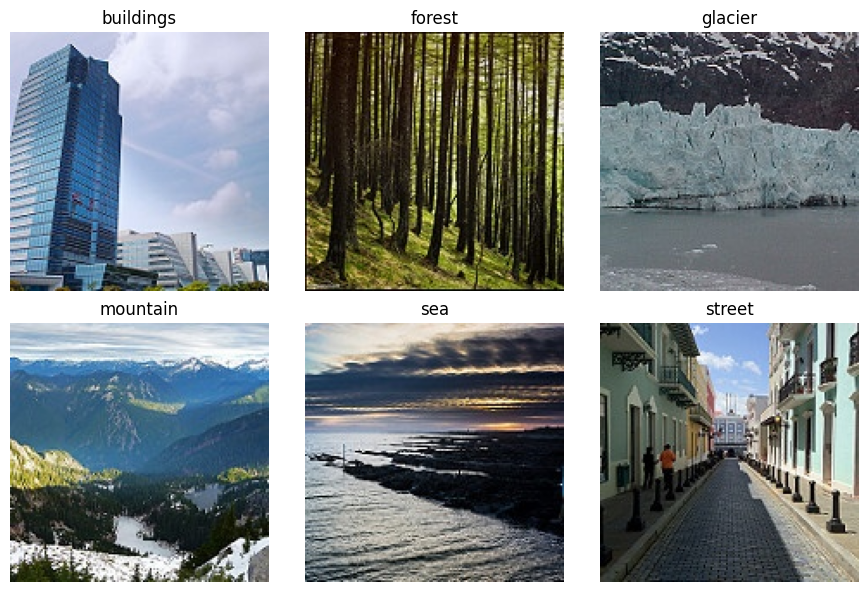

In [ ]:
#Visualize one image per class

plt.figure(figsize=(9, 6))
for i, class_name in enumerate(class_names):
    class_path = os.path.join(train_dir, class_name)
    img = plt.imread(os.path.join(class_path, os.listdir(class_path)[1]))
    plt.subplot(2, 3, i+1)
    plt.imshow(img)
    plt.title(class_name)
    plt.axis("off")
plt.tight_layout()
plt.show()

#Modelo base de Deep learning

El modelo desarrollado en la primera iteración corresponde a una red neuronal convolucional (CNN) para la clasificación del dataset. La arquitectura se compone de tres bloques convolucionales seguidos de operaciones de _max pooling_, una capa de aplanamiento y y dos capas densas. . La estructura permite que el modelo extraiga las características visuales más relevantes de las imágenes. La función de activación utilzada en las capas convolucionales y densas es _ReLU_, y la capa de salida emplea _softmax_ dado que es un problema de clasificación múltiple.

Para favorecer la generalización del modelo, se integró una capa de _data augmentation_ al inicio de la arquitectura. La capa aplica transformaciones aleatorias sobre las imágenes de entrada para generar variaciones artificiales en el dataset de entrenamiento y evitar la memorización. En conjunto con la normalización de píxeles, ambas técnicas contribuyen a estabilizar el aprendizaje del modelo.

El modelo fue entrenado con el optimizador Adam, utilizando un _learning rate_ de 1x10e-4 para tener una convergencia más controlada. Además, se incorporó una capa de _Dropout_ con una tasa del 30 % después de la capa densa intermedia. Esto con el propósito de reducir la dependencia del modelo hacia neuronas específica.

La función de pérdida seleccionada fue _sparse categorical crossentropy_, adecuada para etiquetas enteras que representan las seis clases del conjunto de datos.

In [ ]:
#Data aughmentation
data_augmentation= keras.Sequential([
    layers.RandomFlip("horizontal"),
     layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])

#First instance for the deep learning model
model_base= keras.Sequential([
    keras.Input(shape=(150,150,3)),
    data_augmentation,
    layers.Rescaling(1./255),
    layers.Conv2D(32,3, activation='relu'),
    layers.MaxPool2D(),
    layers.Conv2D(64,3, activation= 'relu'),
    layers.MaxPool2D(),
    layers.Conv2D(128,3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(6, activation='softmax')]
)
optimizer = keras.optimizers.Adam(learning_rate=1e-4)
model_base.compile(optimizer=optimizer, loss= 'sparse_categorical_crossentropy', metrics=['accuracy'])

model_base.summary()



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,829,126 (18.42 MB)

 Trainable params: 4,829,126 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

Durante el entrenamiento se emplearon los callbacks _ModelCheckpoint_ y _EarlyStopping_. Éstas permiten guardar automáticamente la mejor versión del modelo y detener el entrenamiento cuando la precisión de validación deja de mejorar. Esta configuración tiene como propósito evitar el sobreajuste conservando los mejores pesos obtenidos.

In [ ]:
#Training the model
callbacks_base = [
    keras.callbacks.ModelCheckpoint("../models/intel_baseline.keras", save_best_only=True),
    keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
]

history_base = model_base.fit(
    train_data,
    validation_data=val_data,
    epochs=20,
    callbacks=callbacks_base
)

Epoch 1/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 19s 39ms/step - accuracy: 0.4222 - loss: 1.4228 - val_accuracy: 0.5818 - val_loss: 1.1680
Epoch 2/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - accuracy: 0.6179 - loss: 1.0234 - val_accuracy: 0.6023 - val_loss: 1.1161
Epoch 3/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - accuracy: 0.6484 - loss: 0.9334 - val_accuracy: 0.6633 - val_loss: 0.9422
Epoch 4/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 20s 33ms/step - accuracy: 0.6690 - loss: 0.8965 - val_accuracy: 0.6890 - val_loss: 0.8516
Epoch 5/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - accuracy: 0.6982 - loss: 0.8292 - val_accuracy: 0.7044 - val_loss: 0.8349
Epoch 6/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 21s 35ms/step - accuracy: 0.7200 - loss: 0.7873 - val_accuracy: 0.7235 - val_loss: 0.7701
Epoch 7/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - accuracy: 0.7187 - loss: 0.7771 - val_accuracy: 0.7178 - val_loss: 0.7903
Epoch 8/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step - accuracy: 0.7292 - loss: 0.7384 - 

# Evaluación del modelo base

Posteriormente, se graficaron las curvas de pérdida y precisión correspondientes al entrenamiento y validación del modelo.


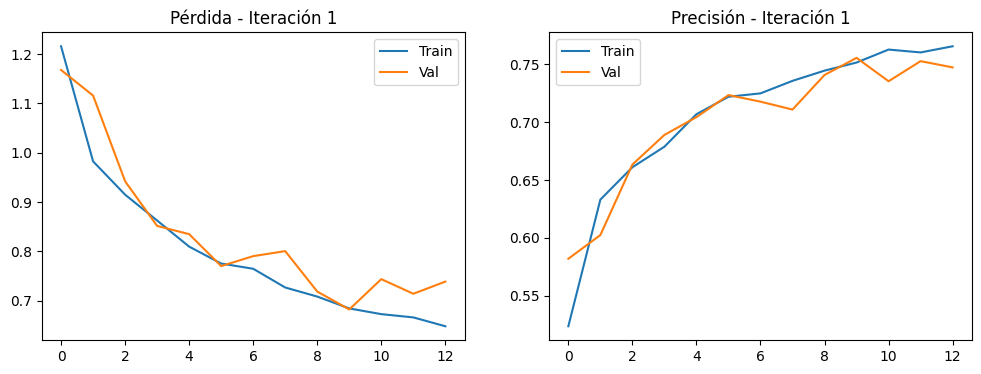

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history_base.history['loss'], label='Train')
plt.plot(history_base.history['val_loss'], label='Val')
plt.title('Pérdida - Iteración 1')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_base.history['accuracy'], label='Train')
plt.plot(history_base.history['val_accuracy'], label='Val')
plt.title('Precisión - Iteración 1')
plt.legend()
plt.show()

In [ ]:
test_loss, test_acc = model_base.evaluate(test_data)
print(f" Pérdida en test: {test_loss:.4f}")
print(f" Precisión en test: {test_acc:.4f}")

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7663 - loss: 0.6630
 Pérdida en test: 0.6854
 Precisión en test: 0.7600


El entrenamiento del modelo mostró un compartamiento de convergencia estable a lo largo de las épocas. En la gráfica de pérdida (_loss_), se observa una disminución continúa en los subconjuntos de _training_ y _validation_. Esto indica que el modelo logra reducir el error progresivamente. La curva de validación presenta valores ligeramente superiores a los de entrenamiento. Sin embargo, ambas curvas mantienen una tendencia descendiente similar, lo que sugiere que el modelo no incurrió en un sobreajuste severo.

Por su parte, la gráfica de precisión (_accuracy_) se aprecua un incremento sostenido con valores cercanos al 78% para entrenamiento y entre 74-76% para validación. La separación entre las curvas evidencia un sobreajuste moderado, propio de modelos que aprenden con mayor detalle los patrones del conjunto de entrenamiento. Este comportamiento puede atribuirse a la complejidad visual del dataset y a la ausencia de técnicas adicionales de regularización. No obstante, las tendencias son consistentes.

En conjunto, el modelo alcanzó un desempeño estable y coherente con la arquitectura propuesta.Las curvas obtenidas confirman que la red convolucional fue capaz de identificar patrones relevantes en las imágenes y generalizar con un nivel de precisión satisfactorio, estableciendo una base sólida para la siguiente etapa de ajuste y mejora del modelo.

Correspondientemente, se utilizó el conjunto de datos de evaluación para medir el rendimiento final del modelo sobre imágenes no vistas durante el entrenamiento.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


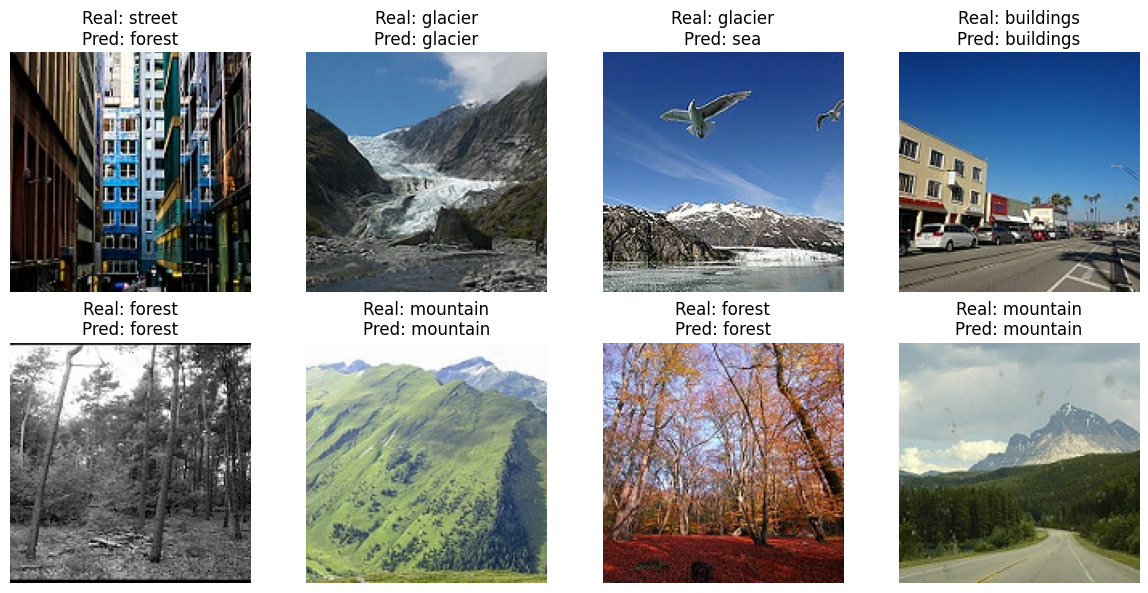

In [ ]:
# Using the test dataset to evaluate the model in one of the batches

for images, labels in test_data.take(1):
    preds = model_base.predict(images)
    pred_classes = np.argmax(preds, axis=1)

    plt.figure(figsize=(12, 6))
    for i in range(8):
        plt.subplot(2, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        true_label = test_data.class_names[labels[i]]
        pred_label = test_data.class_names[pred_classes[i]]
        plt.title(f"Real: {true_label}\nPred: {pred_label}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

Al evaluar el modelo sobre el conjunto de prueba, se observó que las predicciones fueron en su mayoría correctas. No obstante, existen algunos casos de confusión en imágenes con composición visual compleja. En particular, el modelo tiende a clasificar erróneamente aquellas escenas que contienen elementos característicos de más de una categoría, como montañas con áreas boscosas o construcciones cercanas al mar. Este comportamiento es esperable, ya que la red convolucional empleada se basa en la detección de patrones visuales dominantes. Es decir, carece de mecanismos de comprensión contextual. Aun así, el modelo muestra una capacidad adecuada para reconocer la clase principal en la mayoría de los casos.

In [ ]:
#Save the model just in case
model_base.save("models/model_base.keras")


#Modelo ajustado

In [ ]:
from tensorflow import keras
from keras import layers

data_aug = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.15),
    layers.RandomZoom(0.2),
], name="data_augmentation")


model_adjusted = keras.Sequential([
    keras.Input(shape=(150, 150, 3)),
    data_aug,
    layers.Rescaling(1./255),

    layers.Conv2D(32, 3, activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Conv2D(64, 3, activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Conv2D(128, 3, activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Conv2D(256, 3, activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.4),

    layers.Dense(6, activation='softmax')
])


optimizer = keras.optimizers.Adam(learning_rate=5e-5)
model_adjusted.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_adjusted.summary()





Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ data_augmentation (Sequential)  │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_6 (Rescaling)         │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 148, 148, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 72, 72, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 34, 34, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 15, 15, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 15, 15, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 256)            │     3,211,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,603,398 (13.75 MB)

 Trainable params: 3,602,438 (13.74 MB)

 Non-trainable params: 960 (3.75 KB)

In [ ]:

callbacks_adjusted = [
    keras.callbacks.ModelCheckpoint(
        "../models/intel_model_iteration2.keras", save_best_only=True
    ),
    keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
]

history_adjusted = model_adjusted.fit(
    train_data,
    validation_data=val_data,
    epochs=25,
    callbacks=callbacks_adjusted
)




Epoch 1/25
329/329 ━━━━━━━━━━━━━━━━━━━━ 26s 67ms/step - accuracy: 0.4672 - loss: 1.6518 - val_accuracy: 0.3235 - val_loss: 2.6524
Epoch 2/25
329/329 ━━━━━━━━━━━━━━━━━━━━ 41s 66ms/step - accuracy: 0.5923 - loss: 1.0780 - val_accuracy: 0.6633 - val_loss: 0.9014
Epoch 3/25
329/329 ━━━━━━━━━━━━━━━━━━━━ 41s 66ms/step - accuracy: 0.6262 - loss: 0.9943 - val_accuracy: 0.6930 - val_loss: 0.8413
Epoch 4/25
329/329 ━━━━━━━━━━━━━━━━━━━━ 21s 65ms/step - accuracy: 0.6512 - loss: 0.9299 - val_accuracy: 0.6918 - val_loss: 0.8590
Epoch 5/25
329/329 ━━━━━━━━━━━━━━━━━━━━ 21s 65ms/step - accuracy: 0.6677 - loss: 0.8882 - val_accuracy: 0.6765 - val_loss: 0.8951
Epoch 6/25
329/329 ━━━━━━━━━━━━━━━━━━━━ 22s 68ms/step - accuracy: 0.6808 - loss: 0.8567 - val_accuracy: 0.6950 - val_loss: 0.8612


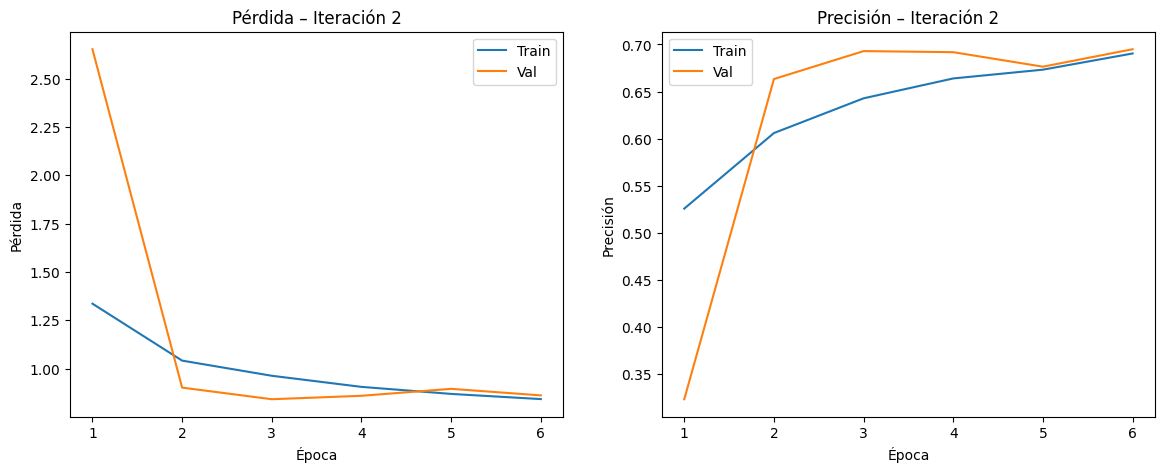

In [ ]:
import matplotlib.pyplot as plt

acc = history_adjusted.history['accuracy']
val_acc = history_adjusted.history['val_accuracy']
loss = history_adjusted.history['loss']
val_loss = history_adjusted.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.plot(epochs, loss, label='Train')
plt.plot(epochs, val_loss, label='Val')
plt.title('Pérdida – Iteración 2')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, acc,  label='Train')
plt.plot(epochs, val_acc, label='Val')
plt.title('Precisión – Iteración 2')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()
plt.show()

In [ ]:
test_loss, test_acc = model_adjusted.evaluate(test_data)
print(f" Pérdida en test: {test_loss:.4f}")
print(f" Precisión en test: {test_acc:.4f}")

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6977 - loss: 0.8485
 Pérdida en test: 0.8976
 Precisión en test: 0.6840


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


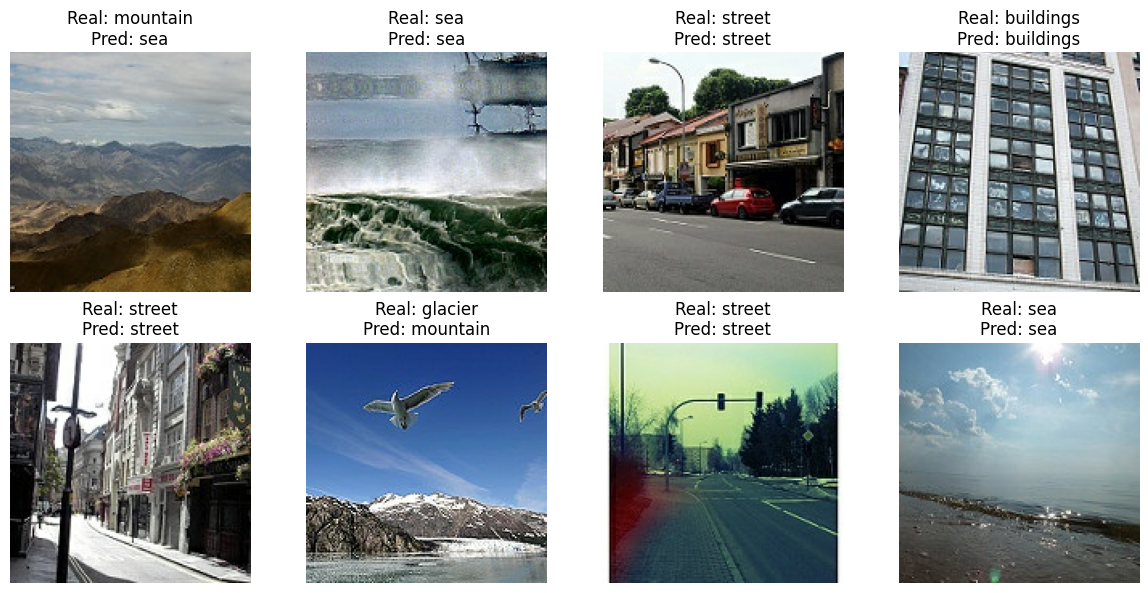

In [ ]:
# Using the test dataset to evaluate the model in one of the batches

for images, labels in test_data.take(1):
    preds = model_adjusted.predict(images)
    pred_classes = np.argmax(preds, axis=1)

    plt.figure(figsize=(12, 6))
    for i in range(8):
        plt.subplot(2, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        true_label = test_data.class_names[labels[i]]
        pred_label = test_data.class_names[pred_classes[i]]
        plt.title(f"Real: {true_label}\nPred: {pred_label}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

In [ ]:
model_adjusted.save("intel_model_final.keras")


#Modelo ajustado

En el modelo ajustado comprende cambios en la resolución de entrada y la arquitectura del modelo con el objetivo de incrementar la capacidad de generalización.

En primera instancia,las imágenes de entrada se procesaron a una resolución de 224×224 píxeles. Esto para capturar con mayor detalle las características espaciales y texturales de cada clase. Además, se incorporó un bloque de normalización por lotes (Batch Normalization) después de cada capa convolucional, con el fin de estabilizar el aprendizaje y acelerar la convergencia del modelo.

La arquitectura final estuvo compuesta por cuatro bloques convolucionales, seguidos de operaciones de MaxPooling para la reducción de dimensionalidad. Posteriormente, se aplicó una capa Flatten. Existe una capa densa intermedia con 256 neuronas y activación ReLU, junto con un Dropout del 30% para mitigar el sobreajuste. Finalmente, la capa de salida utilizó activación softmax para la clasificación multiclase de las seis categorías.

Durante el entrenamiento, se empleó el optimizador Adam con una tasa de aprendizaje ajustada a 2e-4

In [20]:
train_dt = tf.keras.preprocessing.image_dataset_from_directory(
    "./intel_dataset/seg_train/seg_train",
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=(224, 224),
    batch_size=32
)

val_dt = tf.keras.preprocessing.image_dataset_from_directory(
    "./intel_dataset/seg_train/seg_train",
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=(224, 224),
    batch_size=32
)


test_dt = tf.keras.preprocessing.image_dataset_from_directory(
    "./intel_dataset/seg_test/seg_test",
    seed=42,
    image_size=(224, 224),
    batch_size=32,
    shuffle=False
)

Found 14034 files belonging to 6 classes.
Using 11228 files for training.
Found 14034 files belonging to 6 classes.
Using 2806 files for validation.
Found 3000 files belonging to 6 classes.


In [4]:
from tensorflow import keras
from keras import layers

data_aug = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.15),
    layers.RandomZoom(0.2),
], name="data_augmentation")


model_2 = keras.Sequential([
    keras.Input(shape=(224, 224, 3)),
    data_aug,
    layers.Rescaling(1./255),

    layers.Conv2D(32, 3, activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Conv2D(64, 3, activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Conv2D(128, 3, activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Conv2D(256, 3, activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),

    layers.Dense(6, activation='softmax')
])


optimizer = keras.optimizers.Adam(learning_rate=2e-4)

model_2.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_2.summary()



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     9,437,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,829,318 (37.50 MB)

 Trainable params: 9,828,358 (37.49 MB)

 Non-trainable params: 960 (3.75 KB)

Así como en el modelo base, se utilizó Early Stopping y Model Checkpoint para evitar el sobreentrenamiento y conservar los mejores pesos.

In [5]:
callbacks_adjusted2 = [
    keras.callbacks.ModelCheckpoint("../models/intel_model_iteration2.keras", save_best_only=True),
    keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
]

history_adjusted2 = model_2.fit(
    train_dt,
    validation_data=val_dt,
    epochs=25,
    callbacks=callbacks_adjusted2
)


Epoch 1/25
351/351 ━━━━━━━━━━━━━━━━━━━━ 55s 131ms/step - accuracy: 0.5061 - loss: 1.7734 - val_accuracy: 0.2349 - val_loss: 3.2685
Epoch 2/25
351/351 ━━━━━━━━━━━━━━━━━━━━ 45s 127ms/step - accuracy: 0.6192 - loss: 1.0414 - val_accuracy: 0.6301 - val_loss: 1.0275
Epoch 3/25
351/351 ━━━━━━━━━━━━━━━━━━━━ 45s 127ms/step - accuracy: 0.6445 - loss: 0.9791 - val_accuracy: 0.6871 - val_loss: 0.8496
Epoch 4/25
351/351 ━━━━━━━━━━━━━━━━━━━━ 45s 130ms/step - accuracy: 0.6811 - loss: 0.8875 - val_accuracy: 0.7338 - val_loss: 0.7135
Epoch 5/25
351/351 ━━━━━━━━━━━━━━━━━━━━ 44s 127ms/step - accuracy: 0.7011 - loss: 0.8447 - val_accuracy: 0.7071 - val_loss: 0.7558
Epoch 6/25
351/351 ━━━━━━━━━━━━━━━━━━━━ 46s 130ms/step - accuracy: 0.7131 - loss: 0.7950 - val_accuracy: 0.7627 - val_loss: 0.6364
Epoch 7/25
351/351 ━━━━━━━━━━━━━━━━━━━━ 46s 130ms/step - accuracy: 0.7347 - loss: 0.7494 - val_accuracy: 0.7847 - val_loss: 0.6052
Epoch 8/25
351/351 ━━━━━━━━━━━━━━━━━━━━ 45s 128ms/step - accuracy: 0.7526 - loss: 0

#Evaluación del modelo ajustado

Posteriormente, se graficaron las curvas de pérdida y precisión correspondientes al entrenamiento y validación del modelo.

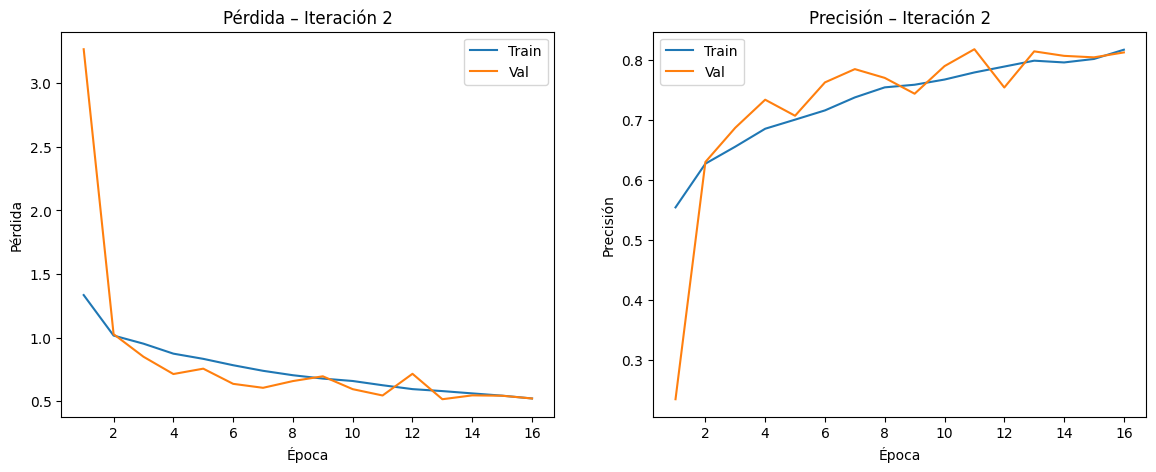

In [6]:
import matplotlib.pyplot as plt

acc = history_adjusted2.history['accuracy']
val_acc = history_adjusted2.history['val_accuracy']
loss = history_adjusted2.history['loss']
val_loss = history_adjusted2.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.plot(epochs, loss, label='Train')
plt.plot(epochs, val_loss, label='Val')
plt.title('Pérdida – Iteración 2')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, acc,  label='Train')
plt.plot(epochs, val_acc, label='Val')
plt.title('Precisión – Iteración 2')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()
plt.show()

En la Figura correspondiente a la Iteración 2, se observa que tanto la curva de pérdida (_loss_) como la de precisión (_accuracy_) presentan un comportamiento estable. Esto indica que el modelo logró aprender de manera consistente a lo largo de las épocas.

En la gráfica de pérdida, se aprecia una disminución pronunciada durante las primeras épocas. Es seguida de una reducción progresiva hasta alcanzar valores cercanos a 0.5 para el conjunto de validación. Las curvas de entrenamiento y validación se mantienen cercanas entre sí, lo que sugiere que no existe sobreajuste significativo.  El modelo mantiene un equilibrio entre la capacidad de aprendizaje y la generalización hacia datos no vistos.

Por otro lado, la gráfica de precisión muestra una tendencia ascendente sostenida en ambos conjuntos. Como se observa, alcanzan valores superiores al 80% de exactitud en las últimas épocas. La similitud en la evolución de las curvas de _training_ y _validation_ refleja que el modelo logra aprender patrones representativos sin depender excesivamente del conjunto de entrenamiento.

In [19]:
test_loss, test_acc = model_2.evaluate(test_dt)
print(f" Pérdida en test: {test_loss:.4f}")
print(f" Precisión en test: {test_acc:.4f}")

94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.8377 - loss: 0.4806
 Pérdida en test: 0.5178
 Precisión en test: 0.8157


Los resultados de evaluación final sobre el conjunto de prueba (_accuracy_ = 0.8157, _loss_ = 0.5178) confirman este comportamiento: el modelo mantiene un rendimiento competitivo, con una diferencia mínima respecto al desempeño obtenido durante la validación.

**Matriz de confusión**

Orden de clases: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step


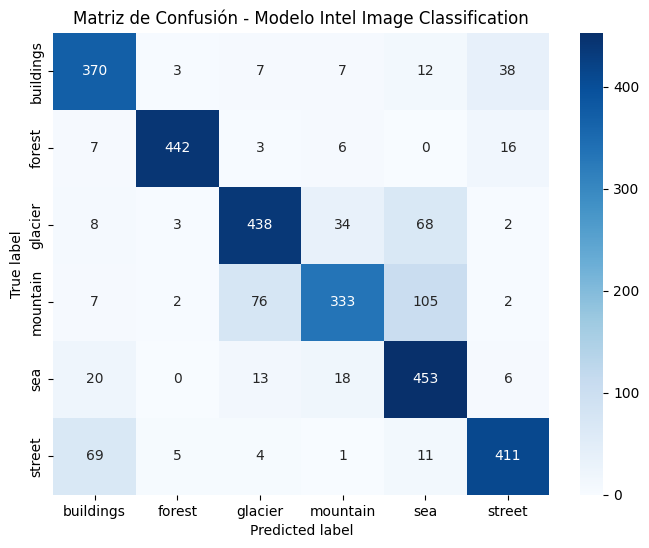

Classification report:

              precision    recall  f1-score   support

   buildings       0.77      0.85      0.81       437
      forest       0.97      0.93      0.95       474
     glacier       0.81      0.79      0.80       553
    mountain       0.83      0.63      0.72       525
         sea       0.70      0.89      0.78       510
      street       0.87      0.82      0.84       501

    accuracy                           0.82      3000
   macro avg       0.82      0.82      0.82      3000
weighted avg       0.82      0.82      0.82      3000



In [26]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

#Obtain the class names directly from the subset to avoid order errors.
class_names = test_dt.class_names
print("Orden de clases:", class_names)

#True class vs. predicted class by the model
y_true = np.concatenate([y for x, y in test_dt], axis=0)
y_pred = model_2.predict(test_dt)
y_pred = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_true, y_pred)

#Plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Matriz de Confusión - Modelo Intel Image Classification')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

#Classification report
print("Classification report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))


La matriz de confusión muestra un desempeño equilibrado entre las seis clases, con una precisión global del 82 %. Las clases _forest, sea y street_ presentan los mayores niveles de acierto, correspondiente a por encima del 80 %. Por su parte, _mountain_ y _glacier_ son las que más confusiones generan entre sí debido a su similitud visual.

El reporte de clasificación confirma esta tendencia: el modelo alcanza un F1-score promedio de 0.82,  En general, el modelo logra distinguir correctamente los diferentes entornos naturales y urbanos. Sin embargo,aún podría beneficiarse de un mejor balance visual en las clases con texturas similares

Correspondientemente, se utilizó el conjunto de datos de evaluación para medir el rendimiento final del modelo sobre imágenes no vistas durante el entrenamiento.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


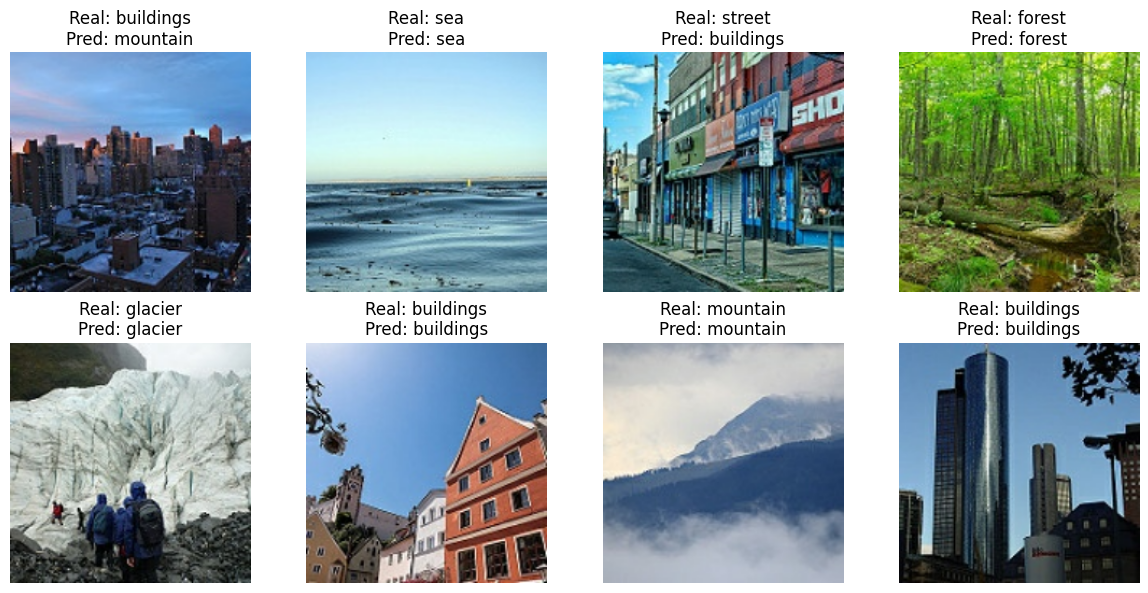

In [35]:
import random
#All images and labels
all_images, all_labels = [], []
for images, labels in test_dt:
    all_images.append(images)
    all_labels.append(labels)

all_images = tf.concat(all_images, axis=0)
all_labels = tf.concat(all_labels, axis=0)

#Eight random indexes
indices = random.sample(range(len(all_images)), 8)
sample_images = tf.gather(all_images, indices)
sample_labels = tf.gather(all_labels, indices)

# Predictions
preds = model_2.predict(sample_images)
pred_classes = np.argmax(preds, axis=1)

#Plots real vs predicted with image.
plt.figure(figsize=(12, 6))
for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.imshow(sample_images[i].numpy().astype("uint8"))
    true_label = test_dt.class_names[sample_labels[i]]
    pred_label = test_dt.class_names[pred_classes[i]]
    plt.title(f"Real: {true_label}\nPred: {pred_label}")
    plt.axis("off")
plt.tight_layout()
plt.show()


Al analizar visualmente una muestra aleatoria de predicciones, se observa que el modelo logra reconocer correctamente la mayoría de las clases, especialmente en escenarios bien definidos y de composición clara. No obstante, se identifican errores en imágenes con ruido visual o elementos mixtos, donde la textura y el color predominante inducen confusiones entre clases similares, como _buildings_ y _street_ o _mountain_ y _glacier_.

Este comportamiento es esperable, dado que las redes convolucionales no necesariamente interpretan el contexto semántico completo de la escena.

In [8]:
model_2.save("model_adjusted.keras")

#Conclusión

En conclusión, el análisis entre el modelo base y el modelo ajustado evidencia una mejora en el desempeño general del sistema de clasificación. El modelo base, entrenado con una resolución de entrada de 150×150 píxeles y una arquitectura de tres bloques convolucionales, alcanzó una precisión en el conjunto de prueba de 0.76. En contraste, el modelo ajustado logró una precisión de 0.82. Este incremento cuantitativo indica que las modificaciones aplicadas favorecieron la convergencia del modelo y una mejor generalización ante datos no vistos.

El aumento en la resolución de entrada permitió capturar patrones visuales más detallado. Esto fue particularmente beneficioso en clases con características espaciales complejas, como _mountain_ y _glacier_. En el modelo base, la menor resolución dificultaba la diferenciación entre texturas similares, lo que se reflejaba en una mayor pérdida de validación. Al incrementar el tamaño de las imágenes, el modelo ajustado pudo procesar información más rica en bordes, tonalidades y contrastes. Esto resultó en una disminución progresiva de la pérdida durante el entrenamiento y una mayor estabilidad en las curvas de validación.

La incorporación de _batch normalization_ también tuvo un impacto relevante en la estabilidad del aprendizaje. Esta técnica permitió mantener distribuciones consistentes en los valores intermedios de activación, evitando oscilaciones abruptas en las actualizaciones de los pesos. En el modelo base, las fluctuaciones entre las métricas de entrenamiento y validación sugerían una tendencia incipiente al sobreajuste, mientras que en el modelo ajustado dichas variaciones se redujeron significativamente. Esto se refleja en una evolución más homogénea de las curvas de pérdida y precisión a lo largo de las épocas.

Asimismo, el uso de la capa _Dropout_ contribuyó a mejorar la capacidad de generalización. El modelo ajustado evitó depender excesivamente de combinaciones específicas de características, lo que resultó en un aprendizaje más equilibrado.

En términos cualitativos, las visualizaciones finales y la matriz de confusión confirman que el modelo ajustado presenta un desempeño más consistente entre clases. Las categorías _forest, sea_ y _street_ mostraron altos niveles de acierto. En cambio, las clases _mountain_ y _glacier_ continuaron generando confusiones, atribuibles a la similitud visual inherente entre ambas. Dado que el conjunto de datos presenta una distribución desigual entre las categorías —particularmente en la clase _sea_—, una alternativa viable para futuras iteraciones consiste en incorporar un esquema de _class weightin_

No obstante, el modelo ajustado logra una mejor delimitación conceptual de las escenas. Esto se observa en las predicciones más precisas y una reducción de errores  respecto al modelo base. En conjunto, estos resultados demuestran que los cambios introducidos no solo mejoraron las métricas cuantitativas, sino también la interpretación visual del comportamiento del modelo.

#Función de aplicación

Saving street.jpg to street (3).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


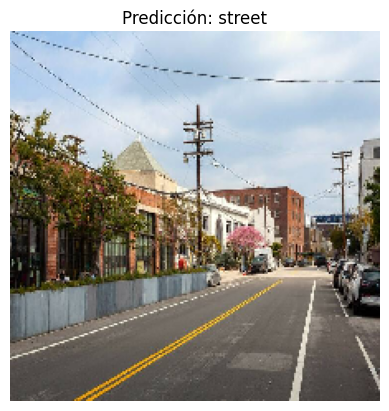

Predicción: street
Probabilidades:
  buildings : 0.356
  forest    : 0.000
  glacier   : 0.003
  mountain  : 0.001
  sea       : 0.003
  street    : 0.637


In [43]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

class_names = test_dt.class_names

def predict_image(model, img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size, color_mode='rgb')
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)

    preds = model.predict(img_array)
    class_idx = np.argmax(preds)
    pred_label = class_names[class_idx]

    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Predicción: {pred_label}")
    plt.show()

    print(f"Predicción: {pred_label}")
    print("Probabilidades:")
    for i, name in enumerate(class_names):
        print(f"  {name:10s}: {preds[0][i]:.3f}")

uploaded = files.upload()
for fname in uploaded.keys():
    predict_image(model_2, fname)


